In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import resample_poly
from sklearn.linear_model import LinearRegression

In [9]:
folder_path =  r'C:\\Mouse5\\2023-07-28T14-47-43\\'
analog_file = os.path.join(folder_path,'AnalogInput.bin')
analog_data = np.fromfile(analog_file, dtype=np.float64).reshape(-1,2).transpose()
fs_analog = 1000 #samples per second
analog_time = np.arange(analog_data[0,:].shape[0])/fs_analog

digital_file = os.path.join(folder_path,'DigitalInput.bin')
digital_data = np.fromfile(digital_file, dtype=np.byte)
fs_digital = 3000 #samples per second
digital_time = np.arange(digital_data.shape[0])/fs_digital

encoder_csv_data = pd.read_csv(os.path.join(folder_path,'RotaryEncoder.csv') )
vr_csv_data = pd.read_csv(os.path.join(folder_path,'VrPosition.csv') )
events_csv_data = pd.read_csv(os.path.join(folder_path,'FrameEvents.csv') )
counter_csv_data = pd.read_csv(os.path.join(folder_path,'FrameCounter.csv') )
quadsync_csv_data = pd.read_csv(os.path.join(folder_path, 'QuadSynch.csv'))

In [10]:
# define fxns for aligning and extracting data
def extract_digital_channel(digital_data, channel_number):
     #channel_number goes from 0 to 7
     return digital_data & (1 << channel_number) > 0

def detect_edges(signal):
    edges =np.where(np.diff(signal) == 1)[0] +1# identify where in time frame signal
    return edges

def detect_rising_edges(signal):
    edges = np.where((np.diff(signal) > 0) & (signal[1:] == 1))[0] + 1 # identify where in time frame signal
    return edges

def align_signal_to_frames(signal_times, photodiode_time):
    aligned_times = []
    aligned_indices = []
    for signal_time in signal_times:
        next_frame_indices = np.where(photodiode_time > signal_time)[0]
        if len(next_frame_indices) > 0:
            aligned_index = next_frame_indices[0]
            aligned_time = photodiode_time[aligned_index]
        else:
            #can't align so ignore
            continue
        aligned_times.append(aligned_time)
        aligned_indices.append(aligned_index)
    
    return np.array(aligned_times), np.array(aligned_indices)

In [11]:
# ensure that photodiode and gpu toggle signal are aligned 
photodiode_signal = extract_digital_channel(digital_data, 2)
gpu_toggle_time = quadsync_csv_data["Time"].values
diode_time = detect_edges(photodiode_signal)/fs_digital

min_nidaq_sample = 10_000
first_diode_time = diode_time[diode_time > (min_nidaq_sample/fs_digital)][0]
allowed_error = 0.010

gpu_v_photodiode = np.empty((gpu_toggle_time.shape[0], 2))
for synch_idx, gpu_t in enumerate(gpu_toggle_time):
    if synch_idx == 0:
        gpu_v_photodiode[synch_idx, 0] = gpu_t
        gpu_v_photodiode[synch_idx, 1] = first_diode_time
    else:
        expected_delta = gpu_t - gpu_v_photodiode[synch_idx-1, 0]
        expected_diode_time = gpu_v_photodiode[synch_idx-1, 1] + expected_delta
        argmin = np.argmin(abs(diode_time - expected_diode_time))
        gpu_v_photodiode[synch_idx, 0] = gpu_t
        gpu_v_photodiode[synch_idx, 1] = diode_time[argmin]

        # if abs(diode_time[argmin] - expected_diode_time) > allowed_error:
        #     print(diode_time[argmin] - expected_diode_time) 
        #     gpu_v_photodiode[synch_idx, 1] = 0
        # else:
        #     gpu_v_photodiode[synch_idx, 1] = diode_time[argmin]

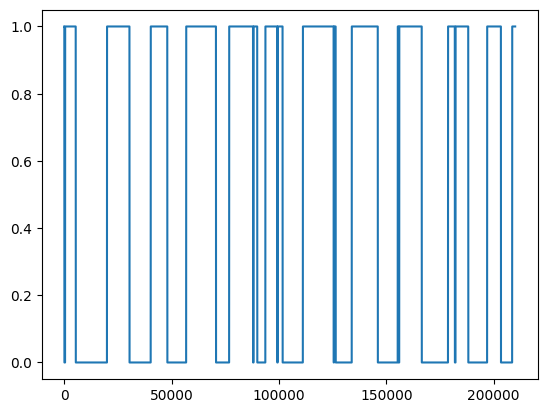

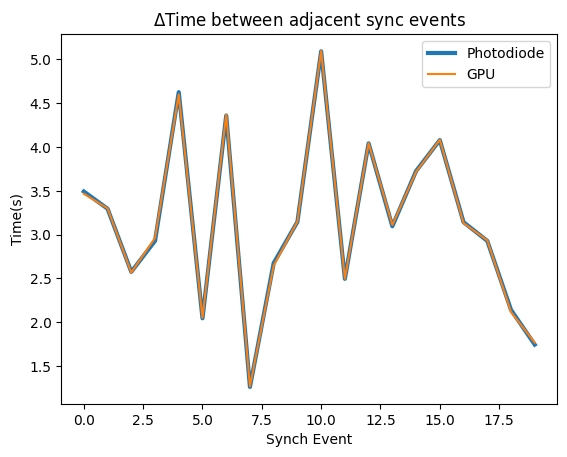

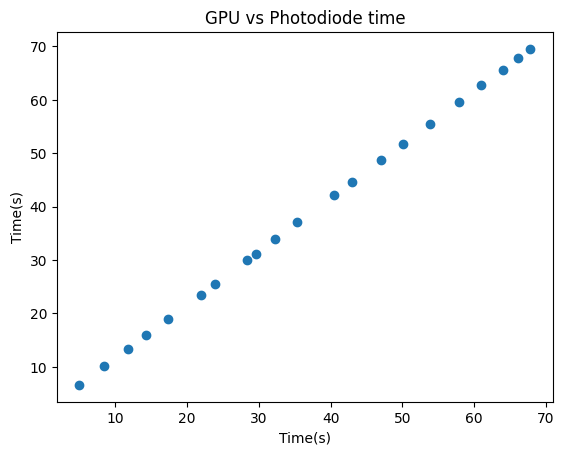

R2=0.9999997135187404 ---- Slope=1.000047948156912 ---- intercept=1.6667346636328375


In [12]:
# visualize photodiode toggle
plt.figure()
plt.plot(photodiode_signal)
plt.show()

# sync events should be aligned for gpu and photodiode
plt.figure()
plt.plot(np.diff(gpu_v_photodiode[:,1]), label="Photodiode", lw=3)
plt.plot(np.diff(gpu_v_photodiode[:,0]), label="GPU")
plt.title("$\Delta$Time between adjacent sync events")
plt.xlabel("Synch Event")
plt.ylabel("Time(s)")
plt.legend()
plt.show()

# Calculate the regression that takes you Time(GPU) -> Time(NIDAQ)
plt.figure()
plt.scatter(gpu_v_photodiode[:,0], gpu_v_photodiode[:,1])
plt.title("GPU vs Photodiode time")
plt.xlabel("Time(s)")
plt.ylabel("Time(s)")
plt.show()

reg = LinearRegression().fit(gpu_v_photodiode[:,0].reshape(-1, 1), gpu_v_photodiode[:,1])
r2 = reg.score(gpu_v_photodiode[:,0].reshape(-1, 1), gpu_v_photodiode[:,1])
slope = reg.coef_[0]
intercept = reg.intercept_
print(f"R2={r2} ---- Slope={slope} ---- intercept={intercept}")

gpu_2_photodiode_time = lambda gpu_time : gpu_time*slope + intercept
photodiode_2_gpu_time =  lambda photodiode_time : (photodiode_time - intercept)/ slope

In [192]:
#  apply regression func to every value in time to make sure that gpu time is converted to rendering time
counter_csv_data["Photodiode_Time"] = counter_csv_data["Time"].apply(gpu_2_photodiode_time)
events_csv_data["Photodiode_Time"] = events_csv_data["Frame.Time"].apply(gpu_2_photodiode_time)
vr_csv_data["Photodiode_Time"] = vr_csv_data["Time"].apply(gpu_2_photodiode_time)
encoder_csv_data["Photodiode_Time"] = encoder_csv_data["RenderElapsedTime"].apply(gpu_2_photodiode_time)
vr_csv_data=vr_csv_data.drop_duplicates(subset=['Photodiode_Time'],keep='last')
#  calculate speed in real time and in tunnel
wheel_dim=0.157
encoder_csv_data['Speed_Absolute']=(encoder_csv_data['RotaryEncoder'].diff()*wheel_dim)/encoder_csv_data['Photodiode_Time'].diff()
encoder_csv_data['Speed_Absolute'].fillna(0,inplace=True)

# scanner digital data extraction
scanner_signal= extract_digital_channel(digital_data,0)
scanner_time =detect_rising_edges(scanner_signal)/fs_digital
aligned_scanner_times = gpu_2_photodiode_time(scanner_time)
scanner_df = pd.DataFrame({
    'Photodiode_Time': aligned_scanner_times,
    'Scanner_Signal': scanner_signal[detect_rising_edges(scanner_signal)]
})

# piezo analog data extraction
piezo_signal = analog_data[0,:] # specify input
piezo_time = np.arange(piezo_signal.shape[0])/fs_analog
aligned_piezo_times = gpu_2_photodiode_time(piezo_time)


,Position,Index,Time,Photodiode_Time
1,0.000000,0,0.049611,1.716348
9,0.000000,1,0.066278,1.733016
11,0.000000,2,0.132000,1.798741
13,0.000000,3,0.152022,1.818763
15,0.000000,4,0.168689,1.835432
...,...,...,...,...
6965,2.826998,3957,68.341461,70.011472
6967,2.826998,3958,68.358128,70.028140
6969,2.826998,3959,68.374795,70.044808
6971,2.826998,3960,68.391462,70.061476


In [204]:
data=pd.DataFrame()
data['Photodiode_Time']=counter_csv_data['Photodiode_Time']
data = data.merge(vr_csv_data[['Photodiode_Time','Position']],on='Photodiode_Time',how='left')
data = data.rename(columns={'Position':'Vr_Position'})
data = data.merge(encoder_csv_data[['Photodiode_Time','RotaryEncoder','Speed_Absolute']],on='Photodiode_Time',how='left')
data = data.rename(columns={'RotaryEncoder':'Encoder_Position'})
# nearest neighbor for analog piezo signal
indices = np.searchsorted(aligned_piezo_times, data['Photodiode_Time'])
indices = np.clip(indices, 0, len(piezo_signal) - 1)  #ensure within valid range for indices
data['Piezo_Signal'] = piezo_signal[indices]

lap_transitions=np.where(np.diff(vr_csv_data['Position']) < -4)[0] + 1
num_laps = len(lap_transitions) + 1

data['Lap_Start'] = 0
data.loc[lap_transitions, 'Lap_Start'] = 1

data = data.merge(events_csv_data[['Photodiode_Time','EventName','EventData']],on='Photodiode_Time',how='left')
data = data.merge(scanner_df, on='Photodiode_Time', how='left')


,Photodiode_Time,Vr_Position,Encoder_Position,Speed_Absolute,Piezo_Signal,Lap_Start,EventName,EventData,Scanner_Signal
0,1.716348,0.000000,0.0,0.0,-0.037296,0,NaN,NaN,NaN
1,1.733016,0.000000,0.0,0.0,0.024831,0,NaN,NaN,NaN
2,1.733016,0.000000,0.0,0.0,0.024831,0,NaN,NaN,NaN
3,1.733016,0.000000,0.0,0.0,0.024831,0,NaN,NaN,NaN
4,1.733016,0.000000,0.0,0.0,0.024831,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4105,70.028140,2.826998,71038.0,0.0,-0.023490,0,NaN,NaN,NaN
4106,70.044808,2.826998,71038.0,0.0,-0.017901,0,NaN,NaN,NaN
4107,70.061476,2.826998,71038.0,0.0,0.002479,0,NaN,NaN,NaN
4108,70.078144,2.826998,71038.0,0.0,0.003794,0,NaN,NaN,NaN
